# Convolution
Transform spatial image to frequency domain using wavelet transformation on Haar Coefficient

In [427]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import os

import pywt
import pywt.data
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

from sklearn.metrics import mean_squared_error
from math import sqrt

from ipynb.fs.full.task1 import convert_pgm_to_matrix, show_image_greyscale

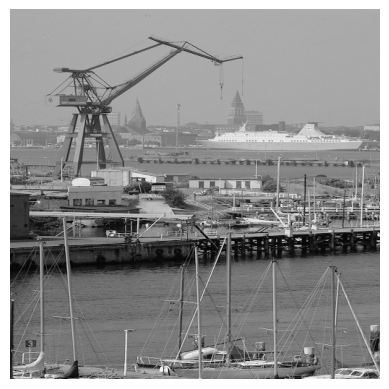

In [428]:
# Load image
im = convert_pgm_to_matrix("./Dataset/kiel.pgm")
show_image_greyscale(im)

In [429]:
# Image Utility function
def show_pic(pic):
    plt.imshow(pic, cmap=plt.cm.gray)

def show_images_4_grids(LL, LH, HL, HH, level):
    titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    fig = plt.figure(figsize=(8, 8))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    fig.text(0.37, 1, f"Wavelet transformation Level {level}")
    plt.show()

## Forward and Inverse Wavelet Transform

In [430]:
def convolve_by_column(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row - 1, num_col))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r:r+2, c]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result

def convolve_by_row(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col - 1))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r, c:c+2]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result


def upsample_rows(matrix):
    """
    Upsample a 2D array along rows by inserting zeros between rows.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((2 * rows, cols))
    upsampled[::2, :] = matrix 

    return upsampled


def upsample_cols(matrix):
    """
    Upsample a 2D array along columns by inserting zeros between columns.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, 2 * cols))
    upsampled[:, ::2] = matrix

    return upsampled

def add_right_padding(im):
    right_padding = np.zeros((im.shape[0], 1))
    return np.concatenate((im, right_padding), axis=1)

def add_bottom_padding(im):
    bottom_padding = np.zeros((1, im.shape[1]))
    return np.concatenate((im, bottom_padding))

def padding_preprocessing_col(im):
    num_columns = im.shape[1]
    if num_columns%2 != 0:
        im = add_right_padding(im)
    
    return im

def padding_preprocessing_row(im):
    num_rows = im.shape[0]
    if num_rows%2 != 0:
        im = add_bottom_padding(im)
    
    return im

def padding_preprocessing(im):
    num_rows = im.shape[0]
    num_cols = im.shape[1]
    if num_rows%2 != 0:
        im = add_bottom_padding(im)
    
    if num_cols%2 != 0:
        im = add_bottom_padding(im)
    
    return im

def downsample_cols(im):
    return im[:, ::2]

def downsample_rows(im):
    return im[::2, :]



In [431]:
def forward_wavelet_transform(im):
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([-1, 1]) / np.sqrt(2)

    L = downsample_cols(convolve_by_row(padding_preprocessing_col(im), low_pass_filter))
    H = downsample_cols(convolve_by_row(padding_preprocessing_col(im), high_pass_filter))

    LL = downsample_rows(convolve_by_column(padding_preprocessing_row(L), low_pass_filter))
    LH = downsample_rows(convolve_by_column(padding_preprocessing_row(L), high_pass_filter))
    HL = downsample_rows(convolve_by_column(padding_preprocessing_row(H), low_pass_filter))
    HH = downsample_rows(convolve_by_column(padding_preprocessing_row(H), high_pass_filter))

    return LL, LH, HL, HH

def add_frequency(a, b):
    if a.shape == b.shape:
        return a + b
    
    diff_in_rows = a.shape[0] - b.shape[0]
    if diff_in_rows > 0:
        a = a[:-diff_in_rows, :]
    elif diff_in_rows < 0:
        b = b[:diff_in_rows, :]

    diff_in_cols = a.shape[1] - b.shape[1]
    if diff_in_cols > 0:
        a = a[:, :-diff_in_cols]
    elif diff_in_cols < 0:
        b = b[:, :diff_in_cols]
    
    return a+b

def inverse_wavelet_transform(LL, LH, HL, HH):
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([1, -1]) / np.sqrt(2)

    reconstructed_L = add_frequency(convolve_by_column(upsample_rows(add_bottom_padding(LH)), high_pass_filter), convolve_by_column(upsample_rows(add_bottom_padding(LL)), low_pass_filter))
    reconstructed_H = convolve_by_column(upsample_rows(add_bottom_padding(HH)), high_pass_filter) + convolve_by_column(upsample_rows(add_bottom_padding(HL)), low_pass_filter)

    reconstructed_image = convolve_by_row(upsample_cols(add_right_padding(reconstructed_L)), low_pass_filter) + convolve_by_row(upsample_cols(add_right_padding(reconstructed_H)), high_pass_filter)

    # Crop to match the original size
    rows, cols = LL.shape[0] * 2, LL.shape[1] * 2
    return reconstructed_image[:rows, :cols]

In [432]:
def forward_wavelet_transform_with_level(image, level):
    result = []
    for l in range(1, level+1):
        LL, LH, HL, HH = forward_wavelet_transform(image)
        image = LL
        show_images_4_grids(LL, LH, HL, HH, l)
        
        result.append(
            {
                "LL": LL, 
                "LH": LH, 
                "HL": HL, 
                "HH": HH
            }
        )
    
    return result

def inverse_wavelet_transform_many_levels(res):
    level = len(res)
    reconstructed_im = None
    
    for l in range(level - 1, -1, -1):
        LL, LH, HL, HH = res[l]["LL"], res[l]["LH"], res[l]["HL"], res[l]["HH"]
        if not reconstructed_im is None:
            LL = reconstructed_im
        
        reconstructed_im = inverse_wavelet_transform(LL, LH, HL, HH)

    return reconstructed_im
        

In [433]:
# Run all image

# dataset_directory = './Dataset'
# for filename in os.listdir(dataset_directory):
#     if filename.endswith(".pgm"):
#         file_with_directory = dataset_directory + "/" + filename
#         print(file_with_directory)
#         im = convert_pgm_to_matrix(file_with_directory)
#         # show_image_greyscale(im)

#         res = forward_wavelet_transform_with_level(im, 3, low_pass_filter, high_pass_filter)
#         reconstructed_image = inverse_wavelet_transform_many_levels(res, low_pass_filter, high_pass_filter)
#         show_pic(reconstructed_image)

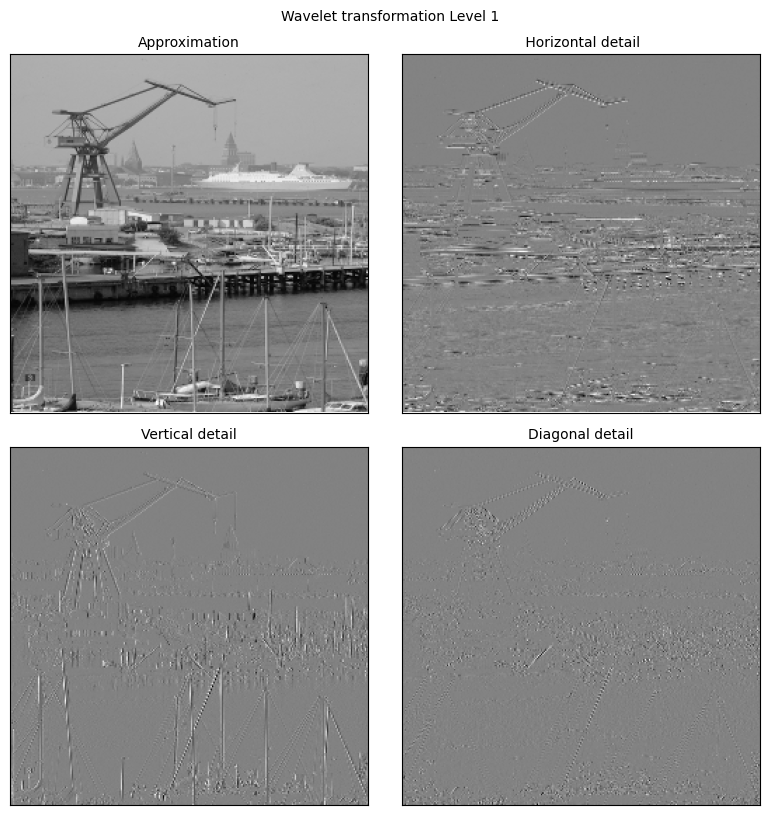

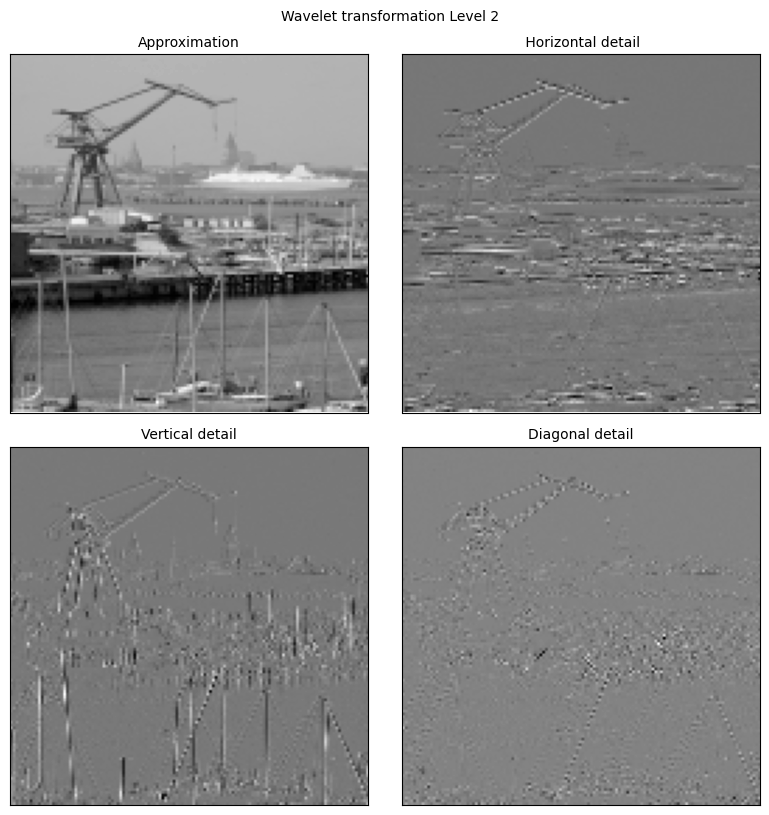

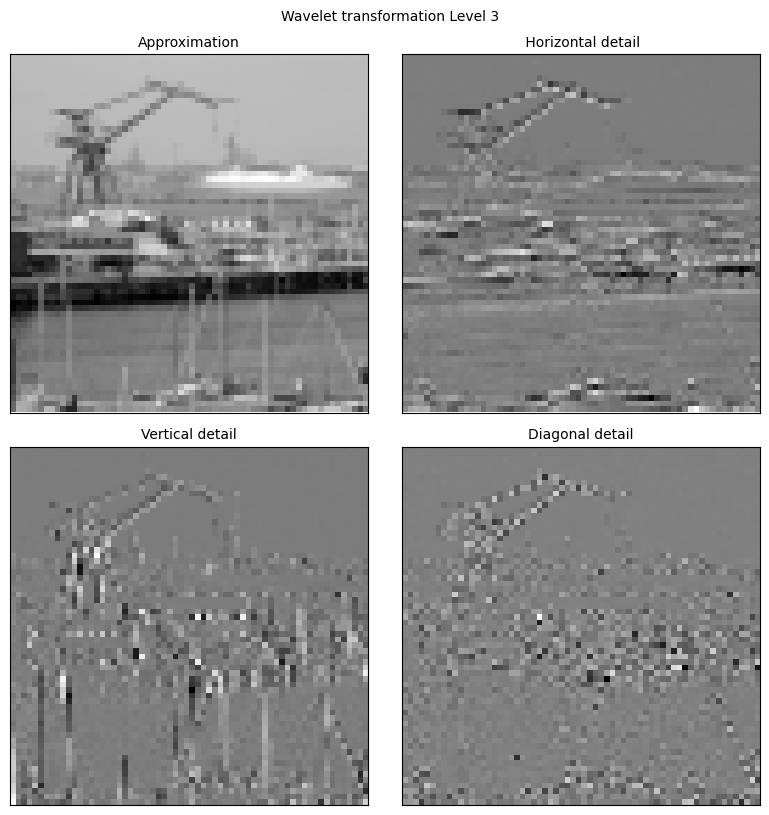

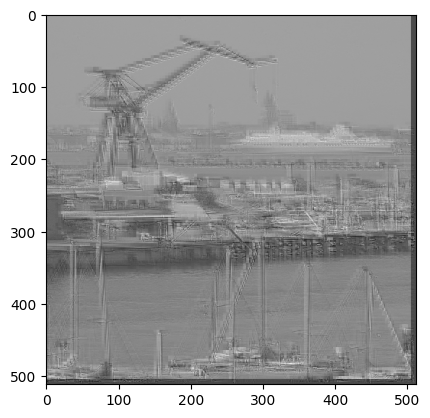

In [434]:
res = forward_wavelet_transform_with_level(im, 3)
reconstructed_image = inverse_wavelet_transform_many_levels(res)
show_pic(reconstructed_image)

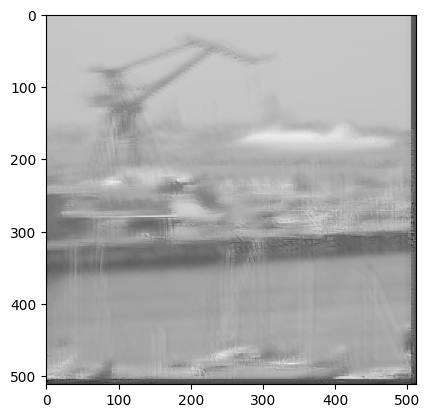

In [435]:
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma
imf = denoise_bilateral(reconstructed_image, sigma_spatial=3)
show_pic(imf)

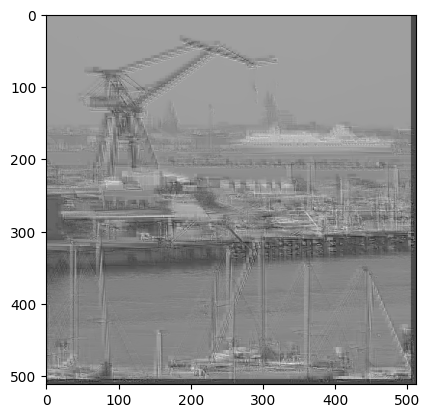

In [436]:
sigma_est = np.mean(estimate_sigma(reconstructed_image))
imd = denoise_nl_means(reconstructed_image, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True)
show_pic(imd)

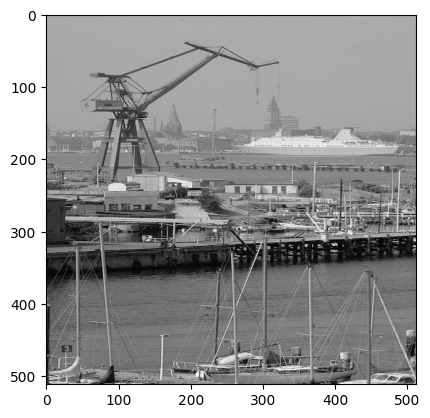

In [437]:
show_pic(im)

In [438]:
imd.shape

(512, 512)

In [439]:
def calculate_mse(original_image, reconstructed_image):
    num_rows, num_cols = original_image.shape
    reconstructed_image = reconstructed_image[:num_rows, :num_cols]

    return mean_squared_error(original_image, reconstructed_image)

In [440]:
calculate_mse(im, imd)

np.float64(0.038077260386910144)

In [441]:
calculate_mse(im, reconstructed_image)

np.float64(0.0381481505851936)

In [442]:
calculate_mse(im, imf)

np.float64(0.026594597023745475)

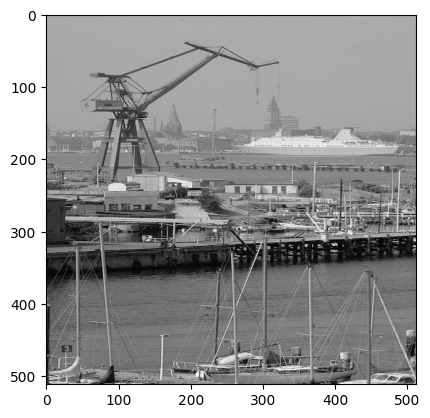

In [443]:
show_pic(im)

In [444]:
from scipy import signal
filter = np.array([low_pass_filter, high_pass_filter])

grad = signal.convolve2d(im, filter)

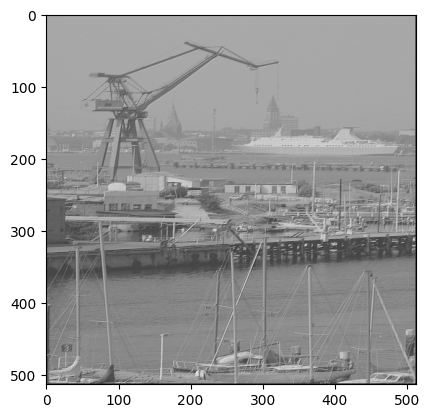

In [445]:
show_pic(grad)

In [446]:
mean_squared_error(grad[:512, :512], im)

np.float64(0.05254413517273107)

In [449]:
a = np.array([1,2])
b = np.array([[3],[4]])

In [450]:
a

array([1, 2])

In [451]:
b

array([[3],
       [4]])

In [452]:
c = np.dot(b,a)

ValueError: shapes (2,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

In [453]:
im[0:0+2, 1]

array([0.6627451, 0.6627451])

In [454]:
im[0, 1:3]

array([0.6627451, 0.6627451])